
# 2.2-kW induction motor, torque-control mode

This example simulates current-vector control of a 2.2-kW induction motor drive
in torque-control mode.


In [1]:
pip install motulator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 2.3 MB/s eta 0:00:00


In [2]:
import numpy as np

from motulator.drive import model
import motulator.drive.control.im as control
from motulator.drive.utils import (
    BaseValues, NominalValues, plot, InductionMachinePars,
    InductionMachineInvGammaPars)

Compute base values based on the nominal values (just for figures).



In [3]:
nom = NominalValues(U=400, I=5, f=50, P=2.2e3, tau=14.6)
base = BaseValues.from_nominal(nom, n_p=2)

Configure the system model.



In [4]:
# Parametrize the machine model using its inverse-Γ parameters
par = InductionMachineInvGammaPars(
    n_p=2, R_s=3.7, R_R=2.1, L_sgm=.021, L_M=.224)
mdl_par = InductionMachinePars.from_inv_gamma_model_pars(par)
machine = model.InductionMachine(mdl_par)
# Use externally specified actual speed w_M(t), defined subsequently below
mechanics = model.ExternalRotorSpeed()
converter = model.VoltageSourceConverter(u_dc=540)
mdl = model.Drive(converter, machine, mechanics)

Configure the control system.



In [5]:
# Machine model parameter estimates
par = InductionMachineInvGammaPars(
    n_p=2, R_s=3.7, R_R=2.1, L_sgm=.021, L_M=.224)
# Set nominal values and limits for reference generation
cfg = control.CurrentReferenceCfg(
    par, max_i_s=1.5*base.i, nom_u_s=base.u, nom_w_s=base.w)
# Create the control system
ctrl = control.CurrentVectorControl(par, cfg, T_s=250e-6, sensorless=True)

Set the torque reference and the actual speed.



In [6]:
# Torque reference steps
ctrl.ref.tau_M = lambda t: (t > .25)*nom.tau - (t > 1.25)*2*nom.tau
# Actual speed varies sinusoidally
mdl.mechanics.w_M = lambda t: .5*(base.w/base.n_p)*np.sin(2*np.pi*1*t)

Create the simulation object and simulate it.



In [7]:
sim = model.Simulation(mdl, ctrl)
sim.simulate(t_stop=2)

Plot results in per-unit values. By omitting the argument `base` you can plot
the results in SI units.



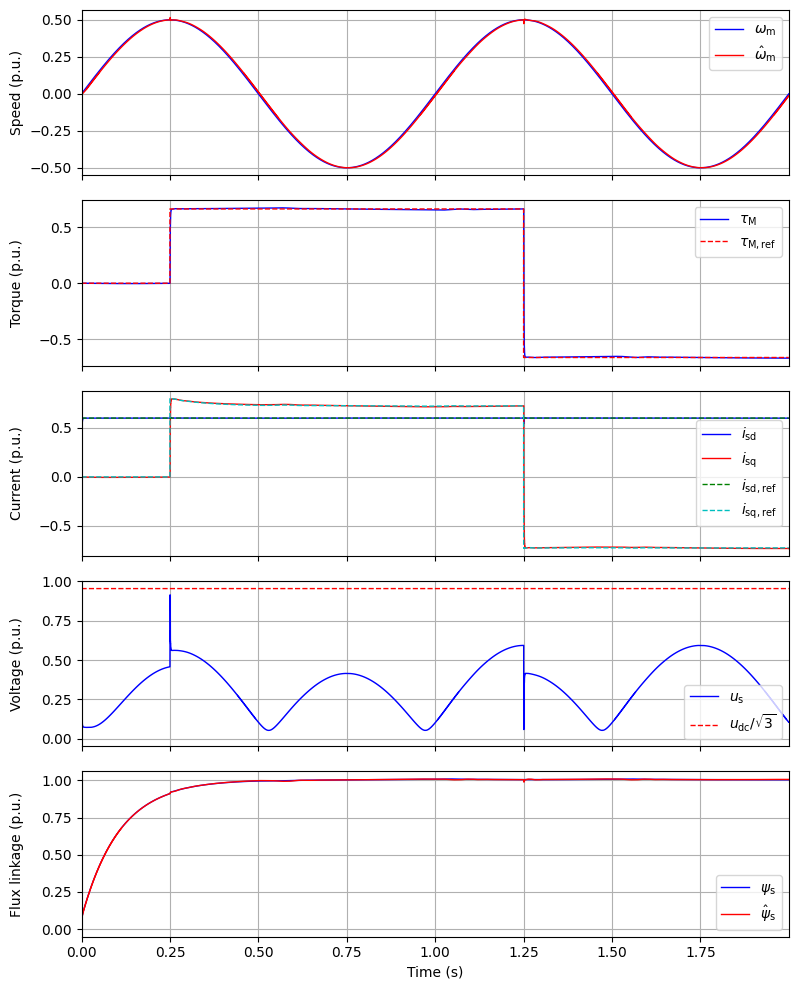

In [8]:
plot(sim, base)